# Bioreactor Optimization
### CHE 883
### Sam Schulte and Lauren Murray

---
### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fancyimpute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import load_model

2025-04-16 21:01:50.588022: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-16 21:01:50.593987: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-16 21:01:50.607776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744851710.629063 1799042 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744851710.635394 1799042 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744851710.653374 1799042 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

---
### Importing Data

In [2]:
data1200 = pd.read_excel("cleaned_bioreactor_data.xlsx", engine="openpyxl", sheet_name="1200")
data1200.head()

,Time (Days),Biomass (mg/mL),Nitrate (mg/mL),C-PC (mg/mL)
0,0.000000,240.530969,NaN,4.324240
1,0.917361,271.447278,1096.597856,4.779300
2,1.883333,318.752372,1160.423633,13.333333
3,4.830556,464.925403,1002.654289,22.496195
4,5.838194,516.453257,1080.242500,27.001522


In [3]:
data300 = pd.read_excel("cleaned_bioreactor_data.xlsx", engine="openpyxl", sheet_name="300")
data300.head()

,Time (Days),Biomass (mg/mL),Nitrate (mg/mL),C-PC (mg/mL)
0,1.152778,153.39213,208.248175,1.565558
1,1.934028,227.84562,253.686131,2.739726
2,3.000000,276.28524,203.321168,5.484863
3,4.059028,345.35655,161.970803,8.230000
4,7.059028,524.76255,49.489051,12.659424


In [4]:
data600 = pd.read_excel("cleaned_bioreactor_data.xlsx", engine="openpyxl", sheet_name="600")
data600.head()

,Time (Days),Biomass (mg/mL),Nitrate (mg/mL),C-PC (mg/mL)
0,1.152778,91.49706,513.941606,3.130000
1,3.000000,252.96246,551.824818,7.560000
2,5.496528,401.86944,413.138686,8.652338
3,7.059028,495.16056,345.620438,11.631819
4,8.079861,567.81999,288.175182,15.362035


In [5]:
data900 = pd.read_excel("cleaned_bioreactor_data.xlsx", engine="openpyxl", sheet_name="900")
data900.head()

,Time (Days),Biomass (mg/mL),Nitrate (mg/mL),C-PC (mg/mL)
0,1.152778,142.62777,670.729927,2.152642
1,1.934028,205.41987,675.656934,5.185910
2,3.000000,289.74069,667.445255,7.432955
3,4.059028,307.68129,708.175182,9.680000
4,7.059028,501.43977,655.620438,13.793103


In [6]:
# check for non numeric columns 
data1200.dtypes

Time (Days)        float64
Biomass (mg/mL)    float64
Nitrate (mg/mL)    float64
C-PC (mg/mL)       float64
dtype: object

---
### REGEM Imputation

In [7]:
#apply REGEM, filling in missing values, using iterative imputer
imputer=IterativeImputer(max_iter=10, random_state=42)
data300_imputed=pd.DataFrame(imputer.fit_transform(data300),columns=data300.columns)
print("Data after REGEM imputation")
print(data300_imputed.head())

Data after REGEM imputation
   Time (Days)  Biomass (mg/mL)  Nitrate (mg/mL)  C-PC (mg/mL)
0     1.152778        153.39213       208.248175      1.565558
1     1.934028        227.84562       253.686131      2.739726
2     3.000000        276.28524       203.321168      5.484863
3     4.059028        345.35655       161.970803      8.230000
4     7.059028        524.76255        49.489051     12.659424


In [8]:
#apply REGEM, filling in missing values, using iterative imputer
imputer=IterativeImputer(max_iter=10, random_state=42)
data600_imputed=pd.DataFrame(imputer.fit_transform(data600),columns=data600.columns)
print("Data after REGEM imputation")
print(data600_imputed.head())

Data after REGEM imputation
   Time (Days)  Biomass (mg/mL)  Nitrate (mg/mL)  C-PC (mg/mL)
0     1.152778         91.49706       513.941606      3.130000
1     3.000000        252.96246       551.824818      7.560000
2     5.496528        401.86944       413.138686      8.652338
3     7.059028        495.16056       345.620438     11.631819
4     8.079861        567.81999       288.175182     15.362035


In [9]:
#apply REGEM, filling in missing values, using iterative imputer
imputer=IterativeImputer(max_iter=10, random_state=42)
data900_imputed=pd.DataFrame(imputer.fit_transform(data900),columns=data900.columns)
print("Data after REGEM imputation")
print(data900_imputed.head())

Data after REGEM imputation
   Time (Days)  Biomass (mg/mL)  Nitrate (mg/mL)  C-PC (mg/mL)
0     1.152778        142.62777       670.729927      2.152642
1     1.934028        205.41987       675.656934      5.185910
2     3.000000        289.74069       667.445255      7.432955
3     4.059028        307.68129       708.175182      9.680000
4     7.059028        501.43977       655.620438     13.793103


In [10]:
#apply REGEM, filling in missing values, using iterative imputer
imputer=IterativeImputer(max_iter=10, random_state=42)
data1200_imputed=pd.DataFrame(imputer.fit_transform(data1200),columns=data1200.columns)
print("Data after REGEM imputation")
print(data1200_imputed.head())

Data after REGEM imputation
   Time (Days)  Biomass (mg/mL)  Nitrate (mg/mL)  C-PC (mg/mL)
0     0.000000       240.530969      1109.191663      4.324240
1     0.917361       271.447278      1096.597856      4.779300
2     1.883333       318.752372      1160.423633     13.333333
3     4.830556       464.925403      1002.654289     22.496195
4     5.838194       516.453257      1080.242500     27.001522


---
## Polynomial Fitting

In [11]:
#adding 3rd order polynomial regression to CPC, nitrate, and biomass to replicate plot in paper
#using imputed data (above) and then generating smooth curves to plot

# Biomass
x300_bio = data300_imputed[["Time (Days)"]] # adds input x to regression
y300_bio = data300_imputed["Biomass (mg/mL)"]  #y target number one, biomass
poly300_bio = PolynomialFeatures(degree=2) #makes 3rd order polynomial 
x300_bio_poly = poly300_bio.fit_transform(x300_bio) #Actually creates the polynomial features from time values
model300_bio = LinearRegression().fit(x300_bio_poly, y300_bio) #trains the regression model to learn a curve that fits your biomass data over time

x300_vals=data300_imputed["Time (Days)"] #grabs full age column again to have range for smoothed values
x300_dense = np.linspace(x300_vals.min(), x300_vals.max(), 200).reshape(-1, 1) #makes 200 evenly spaced time points between first and last day and gives smooth line when predicting values between them

x300_dense_bio = poly300_bio.transform(x300_dense) #Turns smooth x-values into polynomial features
y300_dense_bio = model300_bio.predict(x300_dense_bio)#Uses the model to predict biomass values at all the smooth time points.

# Nitrate
nitrate_data300_imputed = data300_imputed.dropna(subset=["Nitrate (mg/mL)"])
x300_nit = nitrate_data300_imputed[["Time (Days)"]]
y300_nit = nitrate_data300_imputed["Nitrate (mg/mL)"]
poly300_nit = PolynomialFeatures(degree=2)
x300_nit_poly = poly300_nit.fit_transform(x300_nit)
model300_nit = LinearRegression().fit(x300_nit_poly, y300_nit)

x300_dense_nit = poly300_nit.transform(x300_dense)
y300_dense_nit = model300_nit.predict(x300_dense_nit)

# C-PC smoothing
cpc_data300_imputed = data300_imputed.dropna(subset=["C-PC (mg/mL)"])
x300_cpc = cpc_data300_imputed[["Time (Days)"]]
y300_cpc = cpc_data300_imputed["C-PC (mg/mL)"]
poly300_cpc = PolynomialFeatures(degree=2)
x300_cpc_poly = poly300_cpc.fit_transform(x300_cpc)
model300_cpc = LinearRegression().fit(x300_cpc_poly, y300_cpc)

x300_dense_cpc = poly300_cpc.transform(x300_dense)
y300_dense_cpc = model300_cpc.predict(x300_dense_cpc)

/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [12]:
# print coefficients for comparison to paper
print(model300_bio.intercept_)
print(model300_bio.coef_)

88.58903027034216
[ 0.         65.65239026 -0.51259778]


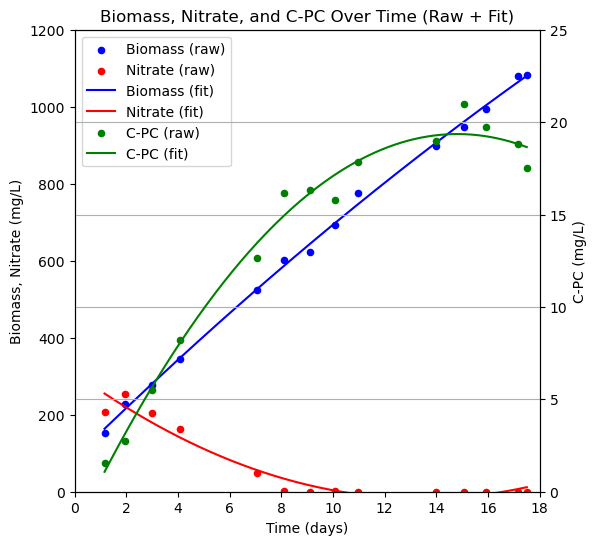

In [13]:
fig, ax1 = plt.subplots(figsize=(6, 6))
x_vals = data300["Time (Days)"] #grabs raw age values from original data to plot raw data


#plotting raw data for biomass and nitrate on left y-axis
ax1.scatter(x_vals, data300["Biomass (mg/mL)"], color='blue', label='Biomass (raw)',s=20)
ax1.scatter(x_vals, data300["Nitrate (mg/mL)"], color='red', label='Nitrate (raw)',s=20)

#draws a smooth biomass curve using predicted values (y_dense_bio/y_dense_nitrate) over a smooth time range (x_dense) for nitrate and biomass
ax1.plot(x300_dense, y300_dense_bio, color='blue', label='Biomass (fit)')
ax1.plot(x300_dense, y300_dense_nit, color='red', label='Nitrate (fit)')

#limits and labels for primary y-axis and x-axis (limits based on paper to make look the same)
ax1.set_xlabel("Time (days)")
ax1.set_ylabel("Biomass, Nitrate (mg/L)")
ax1.set_xlim(0, 18)
ax1.set_ylim(0, 1200)

#adds CPC on right axis
ax2 = ax1.twinx() #twin function creates secondary y-axis that shares same x-axis but has different units and limits than primary y-axis
#plots raw CPC data
ax2.scatter(data300["Time (Days)"], data300["C-PC (mg/mL)"], color='green', label='C-PC (raw)', s=20)
#plots smoothed fitted line over raw data
ax2.plot(x300_dense, y300_dense_cpc, color='green', label='C-PC (fit)')

#labels secondary y-axis and adds scale
ax2.set_ylabel("C-PC (mg/L)")
ax2.set_ylim(0, 25)

#combines legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

#adds title
plt.title("Biomass, Nitrate, and C-PC Over Time (Raw + Fit)")
#adds gridlines
plt.grid(True)

plt.show()

In [14]:
#adding 3rd order polynomial regression to CPC, nitrate, and biomass to replicate plot in paper
#using imputed data (above) and then generating smooth curves to plot

# Biomass
x600_bio = data600_imputed[["Time (Days)"]] # adds input x to regression
y600_bio = data600_imputed["Biomass (mg/mL)"]  #y target number one, biomass
poly600_bio = PolynomialFeatures(degree=2) #makes 3rd order polynomial 
x600_bio_poly = poly600_bio.fit_transform(x600_bio) #Actually creates the polynomial features from time values
model600_bio = LinearRegression().fit(x600_bio_poly, y600_bio) #trains the regression model to learn a curve that fits your biomass data over time

x600_vals=data600_imputed["Time (Days)"] #grabs full age column again to have range for smoothed values
x600_dense = np.linspace(x600_vals.min(), x600_vals.max(), 200).reshape(-1, 1) #makes 200 evenly spaced time points between first and last day and gives smooth line when predicting values between them

x600_dense_bio = poly600_bio.transform(x600_dense) #Turns smooth x-values into polynomial features
y600_dense_bio = model600_bio.predict(x600_dense_bio)#Uses the model to predict biomass values at all the smooth time points.

# Nitrate
nitrate_data600_imputed = data600_imputed.dropna(subset=["Nitrate (mg/mL)"])
x600_nit = nitrate_data600_imputed[["Time (Days)"]]
y600_nit = nitrate_data600_imputed["Nitrate (mg/mL)"]
poly600_nit = PolynomialFeatures(degree=2)
x600_nit_poly = poly600_nit.fit_transform(x600_nit)
model600_nit = LinearRegression().fit(x600_nit_poly, y600_nit)

x600_dense_nit = poly600_nit.transform(x600_dense)
y600_dense_nit = model600_nit.predict(x600_dense_nit)

# C-PC smoothing
cpc_data600_imputed = data600_imputed.dropna(subset=["C-PC (mg/mL)"])
x600_cpc = cpc_data600_imputed[["Time (Days)"]]
y600_cpc = cpc_data600_imputed["C-PC (mg/mL)"]
poly600_cpc = PolynomialFeatures(degree=2)
x600_cpc_poly = poly600_cpc.fit_transform(x600_cpc)
model600_cpc = LinearRegression().fit(x600_cpc_poly, y600_cpc)

x600_dense_cpc = poly600_cpc.transform(x600_dense)
y600_dense_cpc = model600_cpc.predict(x600_dense_cpc)

/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [15]:
# print coefficients for comparison to paper
print(model600_bio.intercept_)
print(model600_bio.coef_)

18.164889826149192
[ 0.         75.45373874 -0.91003229]


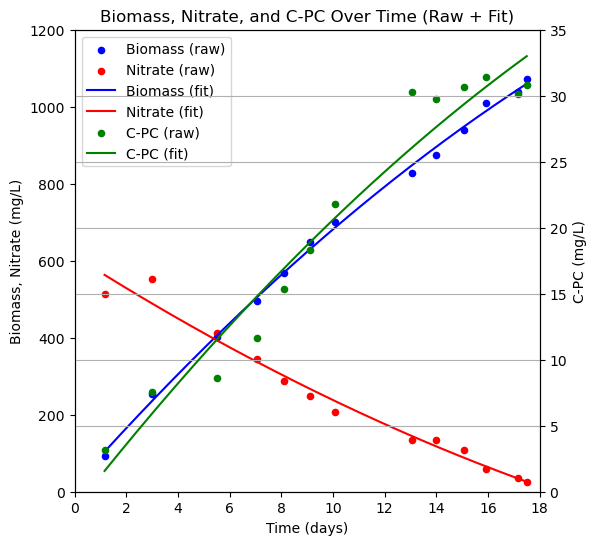

In [16]:
fig, ax1 = plt.subplots(figsize=(6, 6))
x_vals = data600["Time (Days)"] #grabs raw age values from original data to plot raw data


#plotting raw data for biomass and nitrate on left y-axis
ax1.scatter(x_vals, data600["Biomass (mg/mL)"], color='blue', label='Biomass (raw)',s=20)
ax1.scatter(x_vals, data600["Nitrate (mg/mL)"], color='red', label='Nitrate (raw)',s=20)

#draws a smooth biomass curve using predicted values (y_dense_bio/y_dense_nitrate) over a smooth time range (x_dense) for nitrate and biomass
ax1.plot(x600_dense, y600_dense_bio, color='blue', label='Biomass (fit)')
ax1.plot(x600_dense, y600_dense_nit, color='red', label='Nitrate (fit)')

#limits and labels for primary y-axis and x-axis (limits based on paper to make look the same)
ax1.set_xlabel("Time (days)")
ax1.set_ylabel("Biomass, Nitrate (mg/L)")
ax1.set_xlim(0, 18)
ax1.set_ylim(0, 1200)

#adds CPC on right axis
ax2 = ax1.twinx() #twin function creates secondary y-axis that shares same x-axis but has different units and limits than primary y-axis
#plots raw CPC data
ax2.scatter(data600["Time (Days)"], data600["C-PC (mg/mL)"], color='green', label='C-PC (raw)', s=20)
#plots smoothed fitted line over raw data
ax2.plot(x600_dense, y600_dense_cpc, color='green', label='C-PC (fit)')

#labels secondary y-axis and adds scale
ax2.set_ylabel("C-PC (mg/L)")
ax2.set_ylim(0, 35)

#combines legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

#adds title
plt.title("Biomass, Nitrate, and C-PC Over Time (Raw + Fit)")
#adds gridlines
plt.grid(True)

plt.show()

In [17]:
#adding 3rd order polynomial regression to CPC, nitrate, and biomass to replicate plot in paper
#using imputed data (above) and then generating smooth curves to plot

# Biomass
x900_bio = data900_imputed[["Time (Days)"]] # adds input x to regression
y900_bio = data900_imputed["Biomass (mg/mL)"]  #y target number one, biomass
poly900_bio = PolynomialFeatures(degree=2) #makes 3rd order polynomial 
x900_bio_poly = poly900_bio.fit_transform(x900_bio) #Actually creates the polynomial features from time values
model900_bio = LinearRegression().fit(x900_bio_poly, y900_bio) #trains the regression model to learn a curve that fits your biomass data over time

x900_vals=data900_imputed["Time (Days)"] #grabs full age column again to have range for smoothed values
x900_dense = np.linspace(x900_vals.min(), x900_vals.max(), 200).reshape(-1, 1) #makes 200 evenly spaced time points between first and last day and gives smooth line when predicting values between them

x900_dense_bio = poly900_bio.transform(x900_dense) #Turns smooth x-values into polynomial features
y900_dense_bio = model900_bio.predict(x900_dense_bio)#Uses the model to predict biomass values at all the smooth time points.

# Nitrate
nitrate_data900_imputed = data900_imputed.dropna(subset=["Nitrate (mg/mL)"])
x900_nit = nitrate_data900_imputed[["Time (Days)"]]
y900_nit = nitrate_data900_imputed["Nitrate (mg/mL)"]
poly900_nit = PolynomialFeatures(degree=2)
x900_nit_poly = poly900_nit.fit_transform(x900_nit)
model900_nit = LinearRegression().fit(x900_nit_poly, y900_nit)

x900_dense_nit = poly900_nit.transform(x900_dense)
y900_dense_nit = model900_nit.predict(x900_dense_nit)

# C-PC smoothing
cpc_data900_imputed = data900_imputed.dropna(subset=["C-PC (mg/mL)"])
x900_cpc = cpc_data900_imputed[["Time (Days)"]]
y900_cpc = cpc_data900_imputed["C-PC (mg/mL)"]
poly900_cpc = PolynomialFeatures(degree=2)
x900_cpc_poly = poly900_cpc.fit_transform(x900_cpc)
model900_cpc = LinearRegression().fit(x900_cpc_poly, y900_cpc)

x900_dense_cpc = poly900_cpc.transform(x900_dense)
y900_dense_cpc = model900_cpc.predict(x900_dense_cpc)

/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [18]:
x900_bio_poly
model900_nit.coef_

array([ 0.        , -7.49090579, -1.0230443 ])

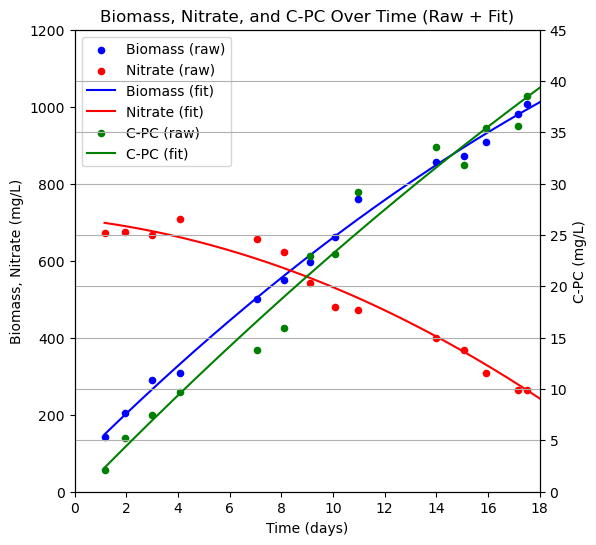

In [19]:
fig, ax1 = plt.subplots(figsize=(6, 6))
x_vals = data900["Time (Days)"] #grabs raw age values from original data to plot raw data


#plotting raw data for biomass and nitrate on left y-axis
ax1.scatter(x_vals, data900["Biomass (mg/mL)"], color='blue', label='Biomass (raw)',s=20)
ax1.scatter(x_vals, data900["Nitrate (mg/mL)"], color='red', label='Nitrate (raw)',s=20)

#draws a smooth biomass curve using predicted values (y_dense_bio/y_dense_nitrate) over a smooth time range (x_dense) for nitrate and biomass
ax1.plot(x900_dense, y900_dense_bio, color='blue', label='Biomass (fit)')
ax1.plot(x900_dense, y900_dense_nit, color='red', label='Nitrate (fit)')

#limits and labels for primary y-axis and x-axis (limits based on paper to make look the same)
ax1.set_xlabel("Time (days)")
ax1.set_ylabel("Biomass, Nitrate (mg/L)")
ax1.set_xlim(0, 18)
ax1.set_ylim(0, 1200)

#adds CPC on right axis
ax2 = ax1.twinx() #twin function creates secondary y-axis that shares same x-axis but has different units and limits than primary y-axis
#plots raw CPC data
ax2.scatter(data900["Time (Days)"], data900["C-PC (mg/mL)"], color='green', label='C-PC (raw)', s=20)
#plots smoothed fitted line over raw data
ax2.plot(x900_dense, y900_dense_cpc, color='green', label='C-PC (fit)')

#labels secondary y-axis and adds scale
ax2.set_ylabel("C-PC (mg/L)")
ax2.set_ylim(0, 45)

#combines legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

#adds title
plt.title("Biomass, Nitrate, and C-PC Over Time (Raw + Fit)")
#adds gridlines
plt.grid(True)

plt.show()

In [20]:
#adding 3rd order polynomial regression to CPC, nitrate, and biomass to replicate plot in paper
#using imputed data (above) and then generating smooth curves to plot

# Biomass
x1200_bio = data1200_imputed[["Time (Days)"]] # adds input x to regression
y1200_bio = data1200_imputed["Biomass (mg/mL)"]  #y target number one, biomass
poly1200_bio = PolynomialFeatures(degree=2) #makes 3rd order polynomial 
x1200_bio_poly = poly1200_bio.fit_transform(x1200_bio) #Actually creates the polynomial features from time values
model1200_bio = LinearRegression().fit(x1200_bio_poly, y1200_bio) #trains the regression model to learn a curve that fits your biomass data over time

x1200_vals=data1200_imputed["Time (Days)"] #grabs full age column again to have range for smoothed values
x1200_dense = np.linspace(x1200_vals.min(), x1200_vals.max(), 200).reshape(-1, 1) #makes 200 evenly spaced time points between first and last day and gives smooth line when predicting values between them

x1200_dense_bio = poly1200_bio.transform(x1200_dense) #Turns smooth x-values into polynomial features
y1200_dense_bio = model1200_bio.predict(x1200_dense_bio)#Uses the model to predict biomass values at all the smooth time points.

# Nitrate
nitrate_data1200_imputed = data1200_imputed.dropna(subset=["Nitrate (mg/mL)"])
x1200_nit = nitrate_data1200_imputed[["Time (Days)"]]
y1200_nit = nitrate_data1200_imputed["Nitrate (mg/mL)"]
poly1200_nit = PolynomialFeatures(degree=2)
x1200_nit_poly = poly1200_nit.fit_transform(x1200_nit)
model1200_nit = LinearRegression().fit(x1200_nit_poly, y1200_nit)

x1200_dense_nit = poly1200_nit.transform(x1200_dense)
y1200_dense_nit = model1200_nit.predict(x1200_dense_nit)

# C-PC smoothing
cpc_data1200_imputed = data1200_imputed.dropna(subset=["C-PC (mg/mL)"])
x1200_cpc = cpc_data1200_imputed[["Time (Days)"]]
y1200_cpc = cpc_data1200_imputed["C-PC (mg/mL)"]
poly1200_cpc = PolynomialFeatures(degree=2)
x1200_cpc_poly = poly1200_cpc.fit_transform(x1200_cpc)
model1200_cpc = LinearRegression().fit(x1200_cpc_poly, y1200_cpc)

x1200_dense_cpc = poly1200_cpc.transform(x1200_dense)
y1200_dense_cpc = model1200_cpc.predict(x1200_dense_cpc)

/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


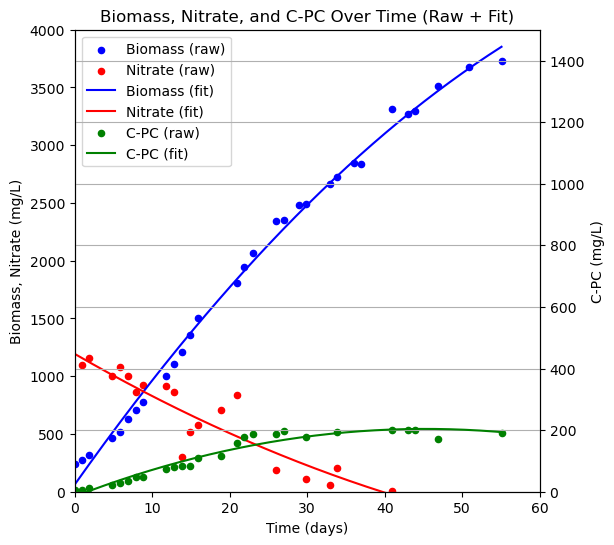

In [21]:
fig, ax1 = plt.subplots(figsize=(6, 6))
x_vals = data1200["Time (Days)"] #grabs raw age values from original data to plot raw data


#plotting raw data for biomass and nitrate on left y-axis
ax1.scatter(x_vals, data1200["Biomass (mg/mL)"], color='blue', label='Biomass (raw)',s=20)
ax1.scatter(x_vals, data1200["Nitrate (mg/mL)"], color='red', label='Nitrate (raw)',s=20)

#draws a smooth biomass curve using predicted values (y_dense_bio/y_dense_nitrate) over a smooth time range (x_dense) for nitrate and biomass
ax1.plot(x1200_dense, y1200_dense_bio, color='blue', label='Biomass (fit)')
ax1.plot(x1200_dense, y1200_dense_nit, color='red', label='Nitrate (fit)')

#limits and labels for primary y-axis and x-axis (limits based on paper to make look the same)
ax1.set_xlabel("Time (days)")
ax1.set_ylabel("Biomass, Nitrate (mg/L)")
ax1.set_xlim(0, 60)
ax1.set_ylim(0, 4000)

#adds CPC on right axis
ax2 = ax1.twinx() #twin function creates secondary y-axis that shares same x-axis but has different units and limits than primary y-axis
#plots raw CPC data
ax2.scatter(data1200["Time (Days)"], data1200["C-PC (mg/mL)"], color='green', label='C-PC (raw)', s=20)
#plots smoothed fitted line over raw data
ax2.plot(x1200_dense, y1200_dense_cpc, color='green', label='C-PC (fit)')

#labels secondary y-axis and adds scale
ax2.set_ylabel("C-PC (mg/L)")
ax2.set_ylim(0, 1500)

#combines legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

#adds title
plt.title("Biomass, Nitrate, and C-PC Over Time (Raw + Fit)")
#adds gridlines
plt.grid(True)

plt.show()

#### Format Polynomial Predicted Values into DataFrame for each Dataset

In [22]:
time300 = np.arange(18) # create time array with values 0-17, as done in original paper
time300_features = poly300_bio.fit_transform(time300.reshape(-1,1)) #Actually creates the polynomial features from time values, which are the same for each model

biomass300_pred = model300_bio.predict(time300_features) #predicted biomass values for time steps
nit300_pred = model300_nit.predict(time300_features) #predicted nitrogen values for time steps
cpc300_pred = model300_cpc.predict(time300_features) #predicted cpc values for time steps

fitted300_df = pd.DataFrame({'Time (Days)': time300, 
                             'Biomass (mg/mL)': biomass300_pred, 
                             'Nitrate (mg/mL)': nit300_pred, 
                             'C-PC (mg/mL)':cpc300_pred})
fitted300_df.head()

,Time (Days),Biomass (mg/mL),Nitrate (mg/mL),C-PC (mg/mL)
0,0,88.589030,308.549615,-2.138810
1,1,153.728823,261.838030,0.665598
2,2,217.843420,218.733146,3.274046
3,3,280.932821,179.234963,5.686531
4,4,342.997027,143.343480,7.903056


In [23]:
time600 = np.arange(18) # create time array with values 0-17, as done in original paper
time600_features = poly600_bio.fit_transform(time600.reshape(-1,1)) #Actually creates the polynomial features from time values, which are the same for each model

biomass600_pred = model600_bio.predict(time600_features) #predicted biomass values for time steps
nit600_pred = model600_nit.predict(time600_features) #predicted nitrogen values for time steps
cpc600_pred = model600_cpc.predict(time600_features) #predicted cpc values for time steps

fitted600_df = pd.DataFrame({'Time (Days)': time600, 
                             'Biomass (mg/mL)': biomass600_pred, 
                             'Nitrate (mg/mL)': nit600_pred, 
                             'C-PC (mg/mL)':cpc600_pred})
fitted600_df.head()

,Time (Days),Biomass (mg/mL),Nitrate (mg/mL),C-PC (mg/mL)
0,0,18.164890,611.586565,-1.257699
1,1,92.708596,569.540282,1.203063
2,2,165.432238,528.533855,3.602857
3,3,236.335815,488.567283,5.941685
4,4,305.419328,449.640567,8.219545


In [24]:
time900 = np.arange(18) # create time array with values 0-17, as done in original paper
time900_features = poly900_bio.fit_transform(time900.reshape(-1,1)) #Actually creates the polynomial features from time values, which are the same for each model

biomass900_pred = model900_bio.predict(time900_features) #predicted biomass values for time steps
nit900_pred = model900_nit.predict(time900_features) #predicted nitrogen values for time steps
cpc900_pred = model900_cpc.predict(time900_features) #predicted cpc values for time steps

fitted900_df = pd.DataFrame({'Time (Days)': time900, 
                             'Biomass (mg/mL)': biomass900_pred, 
                             'Nitrate (mg/mL)': nit900_pred, 
                             'C-PC (mg/mL)':cpc900_pred})
fitted900_df.head()

,Time (Days),Biomass (mg/mL),Nitrate (mg/mL),C-PC (mg/mL)
0,0,72.884046,708.394048,-0.606880
1,1,138.974572,699.880097,1.954695
2,2,203.426212,689.320059,4.476118
3,3,266.238968,676.713931,6.957387
4,4,327.412839,662.061716,9.398504


In [25]:
time1200 = np.arange(56) # create time array with values 0-55, as done in original paper
time1200_features = poly1200_bio.fit_transform(time1200.reshape(-1,1)) #Actually creates the polynomial features from time values, which are the same for each model

biomass1200_pred = model1200_bio.predict(time1200_features) #predicted biomass values for time steps
nit1200_pred = model1200_nit.predict(time1200_features) #predicted nitrogen values for time steps
cpc1200_pred = model1200_cpc.predict(time1200_features) #predicted cpc values for time steps

fitted1200_df = pd.DataFrame({'Time (Days)': time1200, 
                             'Biomass (mg/mL)': biomass1200_pred, 
                             'Nitrate (mg/mL)': nit1200_pred, 
                             'C-PC (mg/mL)':cpc1200_pred})
fitted1200_df.head()

,Time (Days),Biomass (mg/mL),Nitrate (mg/mL),C-PC (mg/mL)
0,0,62.755571,1193.011602,-15.279506
1,1,157.190226,1154.556892,-5.689214
2,2,250.677447,1116.534658,3.686594
3,3,343.217234,1078.944901,12.847918
4,4,434.809588,1041.787621,21.794757


---
## ANN

#### Format Training Data

In [26]:
# Need to define output data as the delta between the current and next time step
def create_training_data(df):
    X = []
    Y = []
    for i in range(len(df) - 1):
        t, x, N, C_PC = df.iloc[i][['Time (Days)', 'Biomass (mg/mL)', 'Nitrate (mg/mL)', 'C-PC (mg/mL)']]
        t_next, x_next, N_next, C_PC_next = df.iloc[i+1][['Time (Days)', 'Biomass (mg/mL)', 'Nitrate (mg/mL)', 'C-PC (mg/mL)']]

        input_vec = [t, x, N, C_PC]
        output_vec = [t_next - t, x_next - x, N_next - N, C_PC_next - C_PC]

        X.append(input_vec)
        Y.append(output_vec)

    return np.array(X), np.array(Y)

# Load and process all 3 experiments
X_all, Y_all = [], []
for df in [fitted300_df, fitted900_df, fitted1200_df]:
    X, Y = create_training_data(df)
    X_all.append(X)
    Y_all.append(Y)

# Stack all together
X_train = np.vstack(X_all)
Y_train = np.vstack(Y_all)

In [27]:
# Create validation set from 600 mg/L data set

X_validation, Y_validation = create_training_data(fitted600_df)

In [28]:
# Scale data to a mean of zero and a mean of 0 and standard deviation of 1

# create instances of scalers
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# fit to training data and scale training data
X_train_scaled = scaler_X.fit_transform(X_train)
Y_train_scaled = scaler_Y.fit_transform(Y_train)

# scale validation data
X_validation_scaled = scaler_X.transform(X_validation)
Y_validation_scaled = scaler_Y.transform(Y_validation)

#### Importing packages and building model

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [ ]:
# Modified version with 600 mg/L experiment used as validation set, other three experiments used as training data
    # (as opposed to using a 15% validation split from the three training experiments)

# === Define the model ===
model = Sequential([
    Dense(64, activation='relu', input_shape=(4,)),   # Input layer (4) → Hidden 1
    Dense(64, activation='relu'),                      # Hidden 2
    Dropout(0.15),                                     # Dropout (keep_prob=0.85)
    Dense(4)                                           # Output layer (Δt, Δx, ΔN, ΔC-PC)
])

# === Compile model ===
model.compile(optimizer=Adam(), loss='mse')

# === Train the model ===
history = model.fit(X_train_scaled, Y_train_scaled,
                    epochs=10000,               # Feel free to reduce to ~1000 to test first
                    batch_size=16,
                    validation_data=(X_validation_scaled, Y_validation_scaled),      # or use an explicit X_val/Y_val if you prefer
                    verbose=1)                  # Set to 1 if you want to watch training live

# === Plot training + validation loss ===
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('ANN Training and Validation Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("Loss_v_Epoch.png")

# === Save model ===
model.save('plectonema_ann_model.h5')
print("Model saved as 'plectonema_ann_model.h5'")


#### Load in Model from Saved Parameters and Fit Validation Set

In [30]:
# === Define the model ===
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(4,)),   # Input layer (4) → Hidden 1
    Dense(64, activation='relu'),                      # Hidden 2
    Dropout(0.15),                                     # Dropout (keep_prob=0.85)
    Dense(4)                                           # Output layer (Δt, Δx, ΔN, ΔC-PC)
])

# === Compile model ===
ann_model.compile(optimizer=Adam(), loss=tf.keras.losses.MeanSquaredError())

# === Load in weights from saved file ====
ann_model.load_weights("plectonema_ann_model_Attempt3.h5")

/home/murra349/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-16 21:02:05.913937: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [31]:
# define initial state as first row of data from validation set
current_state = scaler_X.transform(np.array([1, data600.loc[0,"Biomass (mg/mL)"], data600.loc[0,"Nitrate (mg/mL)"], data600.loc[0,"C-PC (mg/mL)"]]).reshape(1, -1))

t_range = range(1, 18) # time range to run through days 1-17
trajectory = [current_state.copy()] # create a list to store each state for future plotting

for t in t_range:
    
    # Predict the delta in scaled space
    delta_scaled = ann_model.predict(current_state, verbose=0)
    
    # Unscale both delta and current state
    delta_unscaled = scaler_Y.inverse_transform(delta_scaled)[0]
    current_state_unscaled = scaler_X.inverse_transform(current_state)[0]
    
    # Add delta to unscaled state
    next_state_unscaled = current_state_unscaled + delta_unscaled
    
    # Re-scale the new state for the next prediction
    current_state = scaler_X.transform(next_state_unscaled.reshape(1, -1))

    # Save the new state
    trajectory.append(current_state.copy())

# Convert trajectory to NumPy array for easier handling
trajectory = np.array(trajectory)
trajectory_unscaled = scaler_X.inverse_transform(trajectory.reshape(-1, trajectory.shape[-1]))

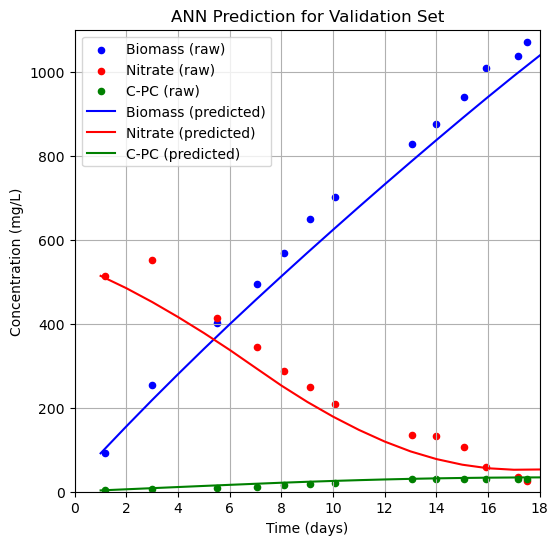

In [32]:
# Plot ANN prediction

fig, ax1 = plt.subplots(figsize=(6, 6))
x_vals = data600["Time (Days)"] #grabs raw age values from original data to plot raw data

ax1.scatter(x_vals, data600["Biomass (mg/mL)"], color='blue', label='Biomass (raw)',s=20)
ax1.scatter(x_vals, data600["Nitrate (mg/mL)"], color='red', label='Nitrate (raw)',s=20)
ax1.scatter(x_vals, data600["C-PC (mg/mL)"], color='green', label='C-PC (raw)',s=20)

plt.plot(trajectory_unscaled[:,0], trajectory_unscaled[:,1],  color='blue', label='Biomass (predicted)')
plt.plot(trajectory_unscaled[:,0], trajectory_unscaled[:,2],  color='red', label='Nitrate (predicted)')
plt.plot(trajectory_unscaled[:,0], trajectory_unscaled[:,3],  color='green', label='C-PC (predicted)')

#limits and labels for primary y-axis and x-axis (limits based on paper to make look the same)
ax1.set_xlabel("Time (days)")
ax1.set_ylabel("Concentration (mg/L)")
ax1.set_xlim(0, 18)
ax1.set_ylim(0, 1100)
plt.legend()

#adds title
plt.title("ANN Prediction for Validation Set")
#adds gridlines
plt.grid(True)

plt.show()

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import threading

UPDATE_FREQ = 20  # print average reward every 20 episodes


# === Environment ===
class BioreactorEnv:
    def __init__(self, ann_model, scaler_X, scaler_Y, data600, max_nitrate=2000):
        self.ann_model = ann_model
        self.scaler_X = scaler_X
        self.scaler_Y = scaler_Y
        self.data600 = data600
        self.max_steps = 17
        self.max_nitrate = max_nitrate
        self.dose_values = [0, 50, 100, 150, 200, 250]
        self.reset()

    def _get_initial_state(self):
        return np.array([
            1,
            self.data600.loc[0, "Biomass (mg/mL)"],
            self.data600.loc[0, "Nitrate (mg/mL)"],
            self.data600.loc[0, "C-PC (mg/mL)"]
        ])

    def reset(self):
        self.current_step = 0
        self.total_nitrate_added = 0
        self.unscaled_state = self._get_initial_state()
        self.scaled_state = self.scaler_X.transform([self.unscaled_state])[0]
        return self.scaled_state

    def step(self, action):
        n_add = self.dose_values[action]
        if self.total_nitrate_added + n_add > self.max_nitrate:
            n_add = 0
        self.total_nitrate_added += n_add

        self.unscaled_state[2] += n_add
        input_scaled = self.scaler_X.transform([self.unscaled_state])[0]

        delta_scaled = self.ann_model.predict(np.array([input_scaled]), verbose=0)
        delta_unscaled = self.scaler_Y.inverse_transform(delta_scaled)[0]

        next_unscaled = self.unscaled_state + delta_unscaled

        self.current_step += 1
        done = self.current_step >= self.max_steps

        if done:
            biomass = max(next_unscaled[1], 1e-6)
            reward = next_unscaled[3] / biomass
        else:
            reward = -0.1

        self.unscaled_state = next_unscaled
        self.scaled_state = self.scaler_X.transform([self.unscaled_state])[0]
        return self.scaled_state, reward, done, {}



# === Actor-Critic Model ===
class ActorCriticModel(Model):
    def __init__(self):
        super().__init__()
        self.dense1 = Dense(200, activation='relu')
        self.logits = Dense(6)  # 6 nitrate dose levels
        self.dense2 = Dense(200, activation='relu')
        self.value = Dense(1)

    def call(self, inputs):
        x = self.dense1(inputs)
        return self.logits(x), self.value(self.dense2(x))

class A3CAgent(threading.Thread):
    def __init__(self, global_model, optimizer, ann_model, scaler_X, scaler_Y, data600):
        super().__init__()
        self.global_model = global_model
        self.optimizer = optimizer
        self.local_model = ActorCriticModel()
        self.local_model(tf.convert_to_tensor(np.zeros((1, 4)), dtype=tf.float32))
        self.local_model.set_weights(global_model.get_weights())
        self.env = BioreactorEnv(ann_model, scaler_X, scaler_Y, data600)

    def run(self):
        global global_episode, global_rewards, global_step, reward_steps, lock

        while True:
            with lock:
                if global_episode >= MAX_EPISODES:
                    break
                episode_num = global_episode
                global_episode += 1

            state = self.env.reset()
            done = False
            episode_reward = 0

            while not done:
                state_tensor = tf.convert_to_tensor(np.expand_dims(state, 0), dtype=tf.float32)
                logits, _ = self.local_model(state_tensor)
                action = tf.random.categorical(logits, 1)[0, 0].numpy()

                next_state, reward, done, _ = self.env.step(action)
                episode_reward += reward
                state = next_state

                with lock:
                    global_step += 1
                    global_rewards.append(reward)
                    if len(global_rewards) >= 20:
                        avg = np.mean(global_rewards[-20:])
                        reward_steps.append(avg)

            with lock:
                if episode_num % UPDATE_FREQ == 0:
                    print(f"[Episode {episode_num}] Avg Reward (last 20 steps): {np.mean(global_rewards[-20:]):.4f}")

# === Training Entry Point ===
def train_a3c(ann_model, scaler_X, scaler_Y, data600, episodes=2000, agents=4):
    global global_episode, global_rewards, global_step, reward_steps, MAX_EPISODES, lock
    global_episode = 0
    global_rewards = []
    reward_steps = []
    global_step = 0
    MAX_EPISODES = episodes
    lock = threading.Lock()

    global_model = ActorCriticModel()
    global_model(tf.convert_to_tensor(np.zeros((1, 4)), dtype=tf.float32))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    agent_threads = [
        A3CAgent(global_model, optimizer, ann_model, scaler_X, scaler_Y, data600)
        for _ in range(agents)
    ]

    for agent in agent_threads:
        agent.start()
    for agent in agent_threads:
        agent.join()

    # Plotting step-based learning curve
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 5))
    plt.plot(reward_steps)
    plt.xlabel("Step")
    plt.ylabel("Moving Avg Reward (20 steps)")
    plt.title("A3C Learning Curve (C-PC / Biomass)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return global_model



[Episode 0] Avg Reward (last 20 steps): -0.0665
[Episode 20] Avg Reward (last 20 steps): -0.0683
[Episode 40] Avg Reward (last 20 steps): -0.0893
[Episode 60] Avg Reward (last 20 steps): -0.0890
[Episode 80] Avg Reward (last 20 steps): -0.0893
[Episode 100] Avg Reward (last 20 steps): -0.0896
[Episode 120] Avg Reward (last 20 steps): -0.0887
[Episode 140] Avg Reward (last 20 steps): -0.0792
[Episode 160] Avg Reward (last 20 steps): -0.0791
[Episode 180] Avg Reward (last 20 steps): -0.0790
[Episode 200] Avg Reward (last 20 steps): -0.0891
[Episode 220] Avg Reward (last 20 steps): -0.0894
[Episode 240] Avg Reward (last 20 steps): -0.0889
[Episode 260] Avg Reward (last 20 steps): -0.0890
[Episode 280] Avg Reward (last 20 steps): -0.0794
[Episode 300] Avg Reward (last 20 steps): -0.0892
[Episode 320] Avg Reward (last 20 steps): -0.0780
[Episode 340] Avg Reward (last 20 steps): -0.0775
[Episode 360] Avg Reward (last 20 steps): -0.0780
[Episode 380] Avg Reward (last 20 steps): -0.0785
[Episo

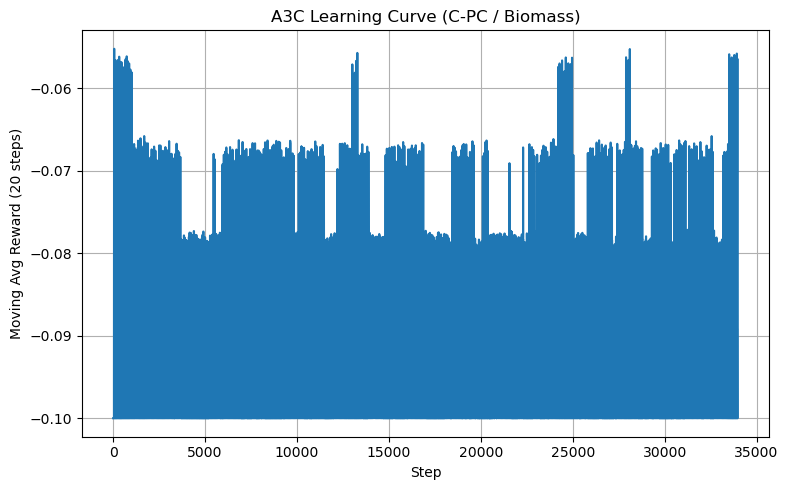

In [48]:
trained_model = train_a3c(ann_model, scaler_X, scaler_Y, data600, episodes=2000, agents=4)



In [49]:
import matplotlib.pyplot as plt
import numpy as np

def simulate_agent(trained_model, ann_model, scaler_X, scaler_Y, data600):
    env = BioreactorEnv(ann_model, scaler_X, scaler_Y, data600)
    state = env.reset()
    done = False

    nitrate_doses = []
    cpc_vals = []
    biomass_vals = []
    days = []

    while not done:
        state_tensor = tf.convert_to_tensor(np.expand_dims(state, 0), dtype=tf.float32)
        logits, _ = trained_model(state_tensor)
        action = tf.random.categorical(logits, 1)[0, 0].numpy()

        # Get nitrate value for the action
        dose = env.dose_values[action]
        nitrate_doses.append(dose)

        # Save current C-PC and biomass from unscaled state
        unscaled = scaler_X.inverse_transform([state])[0]
        days.append(unscaled[0])
        biomass_vals.append(unscaled[1])
        cpc_vals.append(unscaled[3])

        # Take step
        state, reward, done, _ = env.step(action)

    # Plot nitrate addition strategy
    plt.figure(figsize=(8, 4))
    plt.plot(days, nitrate_doses, marker='o')
    plt.xlabel("Day")
    plt.ylabel("Nitrate Added (mg/L)")
    plt.title("Agent’s Nitrate Dosing Strategy Over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional: return for more plots
    return days, nitrate_doses, biomass_vals, cpc_vals


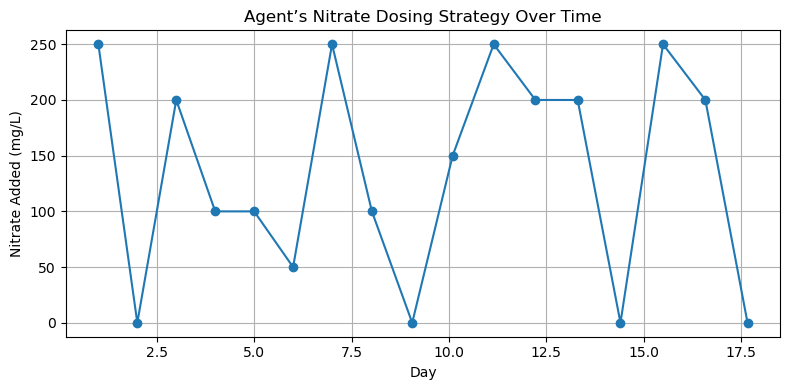

([np.float64(1.0),
  np.float64(1.9999899864196777),
  np.float64(2.999978721141815),
  np.float64(3.999966561794281),
  np.float64(4.999953269958496),
  np.float64(5.999937355518341),
  np.float64(6.99992036819458),
  np.float64(8.02296793460846),
  np.float64(9.058367729187012),
  np.float64(10.096328139305115),
  np.float64(11.149979829788208),
  np.float64(12.221369862556458),
  np.float64(13.306638836860657),
  np.float64(14.405251026153564),
  np.float64(15.497870326042175),
  np.float64(16.58503544330597),
  np.float64(17.667810320854187)],
 [250, 0, 200, 100, 100, 50, 250, 100, 0, 150, 250, 200, 200, 0, 250, 200, 0],
 [np.float64(91.49705999999992),
  np.float64(158.98607367187492),
  np.float64(225.8232013574218),
  np.float64(307.0621692529296),
  np.float64(394.114995180664),
  np.float64(486.23290747314445),
  np.float64(580.3680393090818),
  np.float64(688.0138370385741),
  np.float64(800.2659656396485),
  np.float64(911.3632022729491),
  np.float64(1029.7414142480468),
  

In [50]:
simulate_agent(trained_model, ann_model, scaler_X, scaler_Y, data600)
